In [0]:
# パッケージのインポート
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Conv2D, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
# データセットの準備
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170500096/170498071 [==============================] - 93s 1us/step


In [0]:
# データセットのシェイプの確認
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


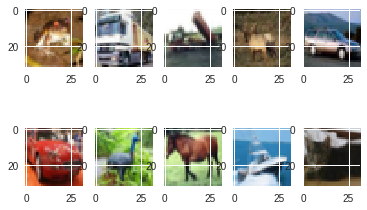

In [0]:
# データセットの画像の確認
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[i])
plt.show()

In [0]:
# データセットのラベルの確認
print(train_labels[0:10])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


In [0]:
# データセットの前処理
train_images = train_images
train_labels = to_categorical(train_labels)
test_images = test_images
test_labels = to_categorical(test_labels)

In [0]:
# データセットの前処理後のシェイプの確認
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [0]:
# 畳み込み層の生成
def conv(filters, kernel_size, strides=1):
    return Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False,
        kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))

In [0]:
# 残差ブロックAの生成
def first_residual_unit(filters, strides):
    def f(x):
        # →BN→ReLU
        x = BatchNormalization()(x)
        b = Activation('relu')(x)

        # 畳み込み層→BN→ReLU
        x = conv(filters // 4, 1, strides)(b)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 畳み込み層→BN→ReLU
        x = conv(filters // 4, 3)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # 畳み込み層→
        x = conv(filters, 1)(x)

        # ショートカットのシェイプサイズを調整
        sc = conv(filters, 1, strides)(b)

        # Add
        return Add()([x, sc])
    return f

In [0]:
# 残差ブロックBの生成
def residual_unit(filters):
    def f(x):
        sc = x
        
        # →BN→ReLU
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 畳み込み層→BN→ReLU
        x = conv(filters // 4, 1)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 畳み込み層→BN→ReLU
        x = conv(filters // 4, 3)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 畳み込み層→
        x = conv(filters, 1)(x)

        # Add
        return Add()([x, sc])
    return f

In [0]:
# 残差ブロックAと残差ブロックB x 17の生成
def residual_block(filters, strides, unit_size):
    def f(x):
        x = first_residual_unit(filters, strides)(x)
        for i in range(unit_size-1):
            x = residual_unit(filters)(x)
        return x
    return f

In [0]:
# 入力データのシェイプ
input = Input(shape=(32,32, 3))

# 畳み込み層
x = conv(16, 3)(input)

# 残差ブロック x 54
x = residual_block(64, 1, 18)(x)
x = residual_block(128, 2, 18)(x)
x = residual_block(256, 2, 18)(x)

# →BN→ReLU
x = BatchNormalization()(x)
x = Activation('relu')(x)

# プーリング層
x = GlobalAveragePooling2D()(x)

# 全結合層
output = Dense(10, activation='softmax', kernel_regularizer=l2(0.0001))(x)

# モデルの作成
model = Model(inputs=input, outputs=output)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# コンパイル
model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.9), metrics=['acc'])

In [0]:
# ImageDataGeneratorの準備
train_gen  = ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True,
    width_shift_range=0.125, 
    height_shift_range=0.125, 
    horizontal_flip=True)
test_gen = ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True)

# データセット全体の統計量を予め計算
for data in (train_gen, test_gen):
    data.fit(train_images)

In [0]:
# LearningRateSchedulerの準備
def step_decay(epoch):
    x = 0.1
    if epoch >= 80: x = 0.01
    if epoch >= 120: x = 0.001
    return x
lr_decay = LearningRateScheduler(step_decay)

In [0]:
# 学習
batch_size = 128
history = model.fit_generator(
    train_gen.flow(train_images, train_labels, batch_size=batch_size),
    epochs=100,
    steps_per_epoch=train_images.shape[0] // batch_size,
    validation_data=test_gen.flow(test_images, test_labels, batch_size=batch_size),
    validation_steps=test_images.shape[0] // batch_size,
    callbacks=[lr_decay])

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
390/390 [==============================] - 348s 892ms/step - loss: 4.7197 - acc: 0.3634 - val_loss: 4.4658 - val_acc: 0.4184
Epoch 2/100
390/390 [==============================] - 309s 793ms/step - loss: 3.8812 - acc: 0.5439 - val_loss: 4.3101 - val_acc: 0.4153
Epoch 3/100
390/390 [==============================] - 310s 796ms/step - loss: 3.2868 - acc: 0.6438 - val_loss: 3.4183 - val_acc: 0.5849
Epoch 4/100
390/390 [==============================] - 310s 794ms/step - loss: 2.8267 - acc: 0.7052 - val_loss: 2.8096 - val_acc: 0.6643
Epoch 5/100
390/390 [==============================] - 310s 794ms/step - loss: 2.4823 - acc: 0.7420 - val_loss: 2.6703 - val_acc: 0.6609
Epoch 6/100
390/390 [==============================] - 311s 797ms/step - loss: 2.2042 - acc: 0.7671 - val_loss: 2.3825 - val_acc: 0.6946
Epoch 7/100
390/390 [==============================] - 310s 795ms/step - loss: 1.9667 - acc: 0.7858 - val_loss: 1.9682 - val_acc: 

In [0]:
# モデルの保存
model.save('resnet.h5')

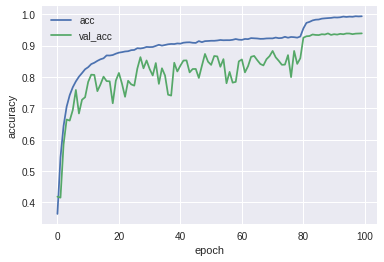

In [0]:
# グラフの表示
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [0]:
# 評価
batch_size = 128
test_loss, test_acc = model.evaluate_generator(
    test_gen.flow(test_images, test_labels, batch_size=batch_size),
    steps=10)
print('loss: {:.3f}\nacc: {:.3f}'.format(test_loss, test_acc ))

loss: 0.483
acc: 0.934


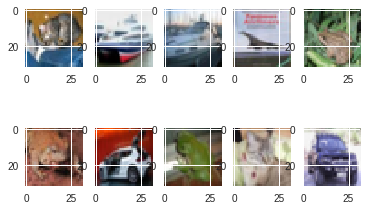

['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile']


In [0]:
# 推論する画像の表示
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_images[i])
plt.show()

# 推論したラベルの表示
test_predictions = model.predict_generator(
    test_gen.flow(test_images[0:10], shuffle = False, batch_size=1),
    steps=10)
test_predictions = np.argmax(test_predictions, axis=1)
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
        'dog', 'frog', 'horse', 'ship', 'truck']
print([labels[n] for n in test_predictions])